In [1]:
import numpy as np
from collections import Counter
import pickle
# import test train split
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
# Accuracy Plot
figure(figsize=(8, 6), dpi=80)

import tensorflow as tf
from imblearn.over_sampling import SMOTE

<Figure size 640x480 with 0 Axes>

In [3]:
with open('challenge2017.pkl', 'rb') as fin:
    res = pickle.load(fin)
    all_data = res['data']
    all_label = res['label']
    print(Counter(all_label))

Counter({'N': 5076, 'O': 2415, 'A': 758, '~': 279})


In [4]:
def extend_ts(ts, length):
    extended = np.zeros(length)
    siglength = np.min([length, ts.shape[0]])
    extended[:siglength] = ts[:siglength]
    return extended 

for i in range(len(all_data)):
    all_data[i] = extend_ts(all_data[i], 18286)
all_data = np.stack(all_data)
all_label = all_label.reshape(-1,1)

sm = SMOTE(random_state=42)
all_data, all_label = sm.fit_resample(all_data, all_label)

print(Counter(all_label))

dict = {'N': 0, 'A': 1, 'O': 2, '~': 3}
all_label = np.vectorize(dict.get)(all_label)

all_label.shape, all_data.shape

Counter({'N': 5076, 'A': 5076, 'O': 5076, '~': 5076})


((20304,), (20304, 18286))

In [5]:
from scipy import signal

def spectrogram(data, nperseg=64, noverlap=32, log_spectrogram = True):
    fs = 300
    f, t, Sxx = signal.spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    Sxx = np.transpose(Sxx,[0,2,1])
    if log_spectrogram:
        Sxx = abs(Sxx) # Make sure, all values are positive before taking log
        mask = Sxx > 0 # We dont want to take the log of zero
        Sxx[mask] = np.log(Sxx[mask])
    return f, t, Sxx
    
def transform(row):
    data_spectrogram = spectrogram(row.reshape(1,row.shape[0]), nperseg = 64, noverlap = 32)[2]
    data_transformed = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
    return data_transformed


In [6]:
all_data = np.apply_along_axis(transform, 1, all_data)
lb = LabelBinarizer()
all_label = lb.fit_transform(all_label)
all_data.shape, all_label.shape

((20304, 1, 570, 33), (20304, 4))

In [7]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape  

((14212, 1, 570, 33), (6092, 1, 570, 33), (14212, 4), (6092, 4))

In [11]:
#here is the new model that is defined, using multi head attention layer

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

class TrainingPlot(tf.keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:

            N = np.arange(0, len(self.losses))

            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            #plt.style.use("seaborn")

            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.title("Training Loss")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.savefig('loss.png')

            plt.clf()
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.plot(N, self.acc, label = "train_acc")
            plt.title("Training Accuracy")
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.savefig('accuracy.png')
            plt.close()

            
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            pass
            # print('Confusion matrix, without normalization')
    
        # print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig('confusion_matrix.png')


In [12]:
input_layer = keras.layers.Input((1, 570, 33))
n_feature_maps = 64
# BLOCK 1

conv_x = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_x = layers.Dropout(0.3)(conv_x)

conv_y = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_y = layers.Dropout(0.3)(conv_y)

conv_z = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
conv_z = layers.Dropout(0.3)(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv2D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_1 = keras.layers.add([shortcut_y, conv_z])
output_block_1 = keras.layers.Activation('relu')(output_block_1)

# BLOCK 2

conv_x = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_x = layers.Dropout(0.3)(conv_x)

conv_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_y = layers.Dropout(0.3)(conv_y)

conv_z = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
conv_z = layers.Dropout(0.3)(conv_z)

# expand channels for the sum
shortcut_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

output_block_2 = keras.layers.add([shortcut_y, conv_z])
output_block_2 = keras.layers.Activation('relu')(output_block_2)

# BLOCK 3

conv_x = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
conv_x = keras.layers.BatchNormalization()(conv_x)
conv_x = keras.layers.Activation('relu')(conv_x)
conv_x = layers.Dropout(0.3)(conv_x)

conv_y = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
conv_y = keras.layers.BatchNormalization()(conv_y)
conv_y = keras.layers.Activation('relu')(conv_y)
conv_y = layers.Dropout(0.3)(conv_y)

conv_z = keras.layers.Conv2D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
conv_z = keras.layers.BatchNormalization()(conv_z)
conv_z = layers.Dropout(0.3)(conv_z)

# no need to expand channels because they are equal
shortcut_y = keras.layers.BatchNormalization()(output_block_2)

output_block_3 = keras.layers.add([shortcut_y, conv_z])
output_block_3 = keras.layers.Activation('relu')(output_block_3)

# x = transformer_encoder(output_block_3, 256, 1, 4, 0.25)

# FINAL

gap_layer = keras.layers.GlobalAveragePooling2D()(output_block_3)

d1 = keras.layers.Dense(128, activation='relu')(gap_layer)
d1 = layers.Dropout(0.3)(d1)
d2 = keras.layers.Dense(128, activation='relu')(d1)
d2 = layers.Dropout(0.3)(d2)

output_layer = keras.layers.Dense(4, activation='softmax')(d2)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 570, 33)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 1, 570, 64)   135232      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 570, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

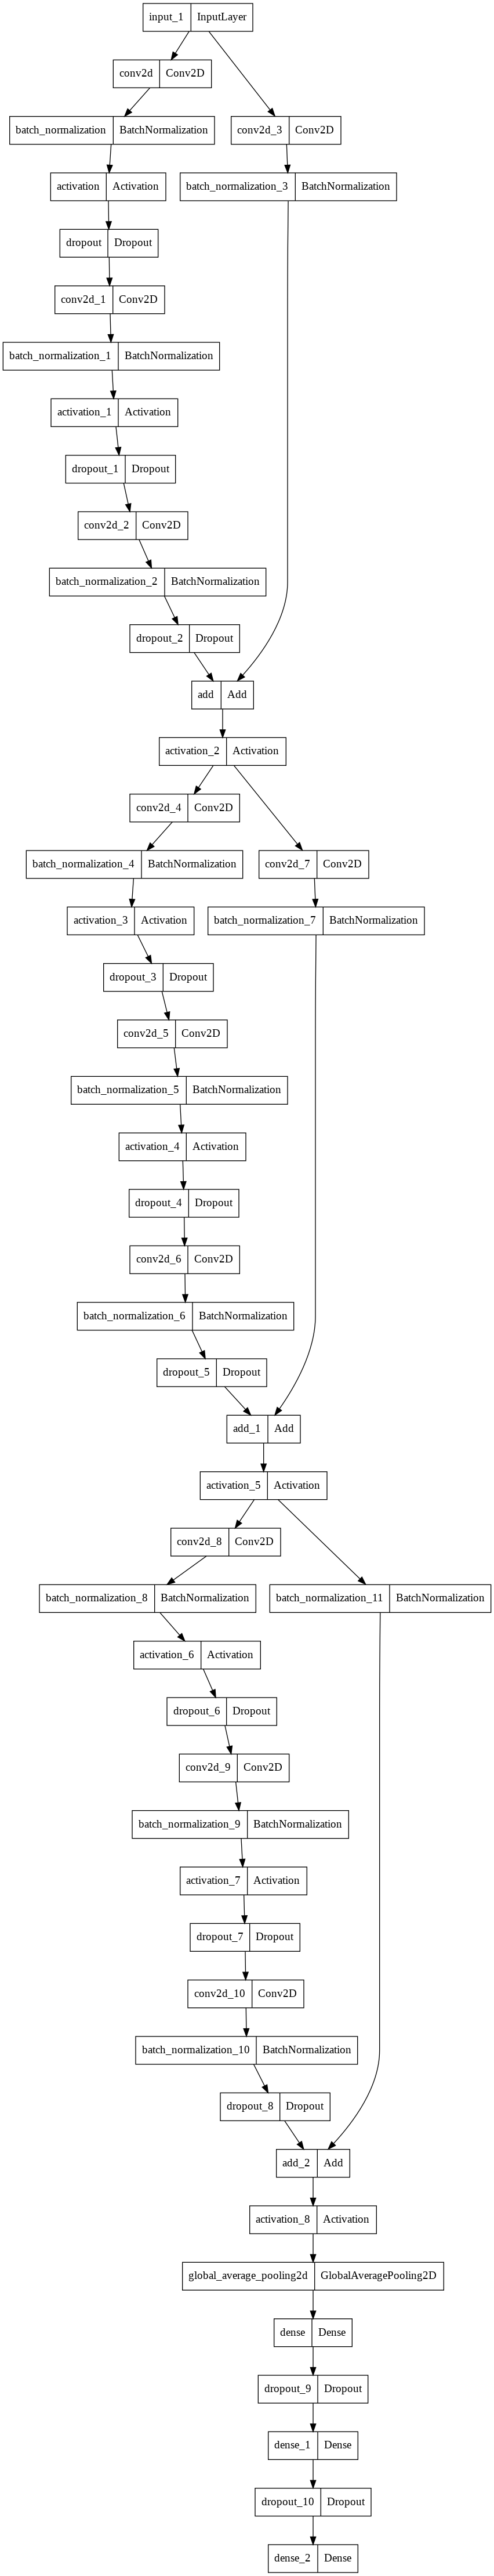

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    callbacks = [TrainingPlot(), tf.keras.callbacks.ModelCheckpoint(
                    filepath = 'Model.{epoch:02d}.hdf5',
                    monitor = 'val_accuracy',
                    save_best_only = True,
                    mode = 'max',
                    save_freq='epoch',
                    options=None,
                    initial_value_threshold=None,
                    )],
                     verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
445/445 [==============================] - 672s 1s/step - loss: 0.9101 - accuracy: 0.5979 - val_loss: 0.7787 - val_accuracy: 0.6694
Epoch 2/50
445/445 [==============================] - 664s 1s/step - loss: 0.7360 - accuracy: 0.6939 - val_loss: 0.8207 - val_accuracy: 0.6717
Epoch 3/50
445/445 [==============================] - 665s 1s/step - loss: 0.6598 - accuracy: 0.7314 - val_loss: 1.4594 - val_accuracy: 0.5391
Epoch 4/50
445/445 [==============================] - 668s 2s/step - loss: 0.5989 - accuracy: 0.7654 - val_loss: 0.6345 - val_accuracy: 0.7503
Epoch 5/50
445/445 [==============================] - 663s 1s/step - loss: 0.5512 - accuracy: 0.7845 - val_loss: 1.0157 - val_accuracy: 0.6220
Epoch 6/50
445/445 [==============================] - 665s 1s/step - loss: 0.5007 - accuracy: 0.8102 - val_loss: 0.5927 - val_accuracy: 0.7750
Epoch 7/50
445/445 [==============================] - 666s 1s/step - loss: 0.4597 - accuracy: 0.8259 - val_loss: 0.6773 - val_accuracy: 0.7426

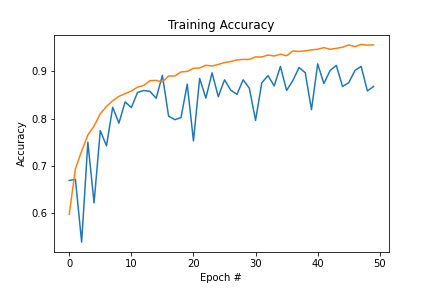

In [25]:
from IPython.display import Image
Image('accuracy.png')

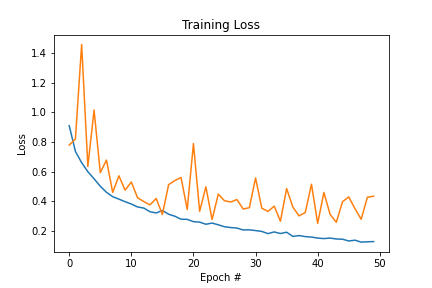

In [26]:
Image('loss.png')

In [27]:
model.evaluate(X_test, y_test)

191/191 [==============================] - 53s 277ms/step - loss: 0.4334 - accuracy: 0.8682


[0.4333588778972626, 0.8681877851486206]

In [20]:
model.evaluate(X_train, y_train)

445/445 [==============================] - 134s 300ms/step - loss: 0.2189 - accuracy: 0.9212


[0.21892161667346954, 0.9211933612823486]

191/191 [==============================] - 54s 277ms/step


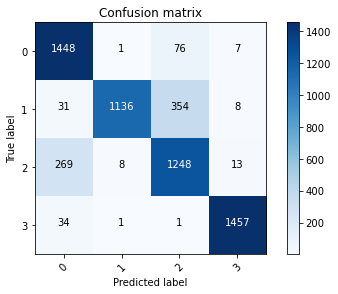

In [23]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = range(4))

In [21]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_true, y_pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      1532
           1       0.99      0.74      0.85      1529
           2       0.74      0.81      0.78      1538
           3       0.98      0.98      0.98      1493

    accuracy                           0.87      6092
   macro avg       0.88      0.87      0.87      6092
weighted avg       0.88      0.87      0.87      6092

